In [1]:
import pandas as pd
import numpy as np

# Semilla para reproducibilidad
np.random.seed(42)

# --- Generación del Dataset Sintético ---

# 1. Variables de tiempo
N = 1000  # Número total de registros (ej. horas/días)
df = pd.DataFrame({
    'Hora': np.random.randint(5, 24, N),  # De 5 AM a 11 PM
    'Dia_Semana': np.random.randint(0, 7, N),
})

# 2. Variables externas
df['Clima_Lluvia'] = np.random.choice([0, 1], N, p=[0.7, 0.3]) # 30% probabilidad de lluvia
df['Temperatura_C'] = np.random.uniform(15, 30, N)

# 3. ETIOUETA (Demanda_Pasajeros): La variable a predecir
# Lógica para la demanda: Alta en horas pico, baja en la noche, menor en fin de semana, mayor si no llueve.
def generar_demanda(row):
    demanda_base = 50 + row['Temperatura_C'] * 2
    
    # Horas Pico (6-9 AM y 17-20 PM)
    if (row['Hora'] >= 6 and row['Hora'] <= 9) or (row['Hora'] >= 17 and row['Hora'] <= 20):
        demanda_base *= 2.5 
    
    # Fin de Semana (Sáb=5, Dom=6)
    if row['Dia_Semana'] >= 5:
        demanda_base *= 0.6 # Menos demanda
        
    # Lluvia (reduce la demanda en algunas estaciones, la aumenta en otras)
    if row['Clima_Lluvia'] == 1:
        demanda_base *= 0.9 
        
    # Añadir ruido y asegurar que sea entero
    return int(demanda_base + np.random.randint(-20, 20))

df['Demanda_Pasajeros'] = df.apply(generar_demanda, axis=1)
df.loc[df['Demanda_Pasajeros'] < 0, 'Demanda_Pasajeros'] = 0 # Asegurar no negativos

# Mostrar las primeras filas del dataset generado
print("### Dataset de Demanda Horaria (Muestra) ###")
print(df.head())

### Dataset de Demanda Horaria (Muestra) ###
   Hora  Dia_Semana  Clima_Lluvia  Temperatura_C  Demanda_Pasajeros
0    11           1             1      20.105807                 79
1    19           2             0      23.121114                242
2    15           5             0      17.312176                 53
3    12           1             1      23.305672                 76
4    11           3             0      23.125572                109


In [3]:
#importamos las librerias necesarias para realizar el entrenamiento de nuestro modelo supervisado
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


Datos de Entrenamiento: 700 registros
Datos de Prueba: 300 registros

Iniciando entrenamiento del modelo Random Forest...
Entrenamiento completado.

### Evaluación de Rendimiento del Modelo ###
Error Cuadrático Medio (MSE): 162.55
Coeficiente de Determinación (R²): 0.9689


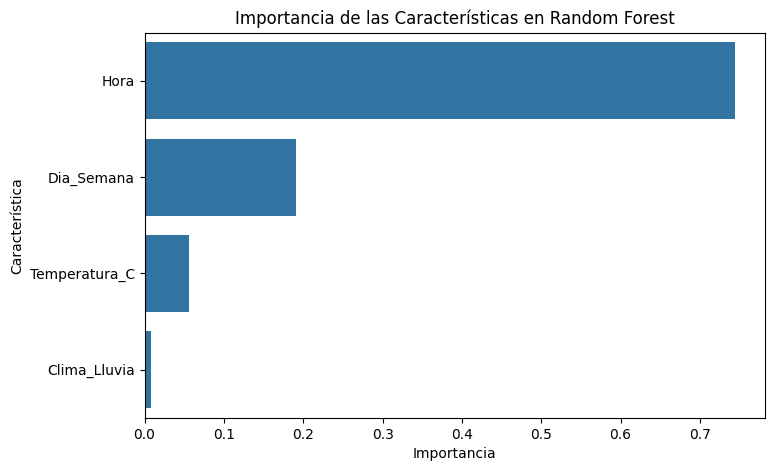


Predicción para la hora pico (8 AM, 25°C): 253 pasajeros.


In [4]:
# --- 3.1. Preparación de Datos ---

# 1. Identificar Features (X) y Etiqueta (y)
FEATURES = ['Hora', 'Dia_Semana', 'Clima_Lluvia', 'Temperatura_C']
LABEL = 'Demanda_Pasajeros'

X = df[FEATURES]
y = df[LABEL]

# 2. Dividir el Dataset en conjuntos de Entrenamiento y Prueba (70/30)
# Regla: El conjunto de entrenamiento se usa para que el modelo aprenda; el de prueba para evaluarlo.
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=42
)

print(f"\nDatos de Entrenamiento: {len(X_train)} registros")
print(f"Datos de Prueba: {len(X_test)} registros")

# --- 3.2. Desarrollo y Entrenamiento del Modelo ---

# 1. Inicializar el Modelo (Random Forest Regressor es robusto y funciona bien con datos tabulares)
modelo = RandomForestRegressor(
    n_estimators=100,  # Número de árboles en el bosque
    random_state=42,
    n_jobs=-1          # Usar todos los núcleos del CPU
)

# 2. Entrenar el Modelo (Aprender de los datos de entrenamiento)
print("\nIniciando entrenamiento del modelo Random Forest...")
modelo.fit(X_train, y_train)
print("Entrenamiento completado.")

# --- 3.3. Evaluación del Modelo ---

# 1. Realizar predicciones sobre el conjunto de prueba
y_pred = modelo.predict(X_test)

# 2. Calcular Métricas de Rendimiento
# MSE: Error Cuadrático Medio (mide el error promedio)
mse = mean_squared_error(y_test, y_pred)
# R2: Coeficiente de Determinación (qué tan bien se ajusta la predicción a los datos reales, 1 es perfecto)
r2 = r2_score(y_test, y_pred)

print("\n### Evaluación de Rendimiento del Modelo ###")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# --- 3.4. Visualización de Resultados (Opcional pero Recomendado) ---

# Mostrar la importancia de las características para la predicción
feature_importances = pd.Series(modelo.feature_importances_, index=FEATURES).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Importancia de las Características en Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()

# --- 3.5. Uso del Modelo (Predicción con Nuevos Datos) ---

# Ejemplo: Predecir la demanda a las 8 AM (Hora pico), Lunes (Día 0), sin lluvia (0), 25°C.
nuevos_datos = pd.DataFrame([[8, 0, 0, 25]], columns=FEATURES)

demanda_estimada = modelo.predict(nuevos_datos)[0]
print(f"\nPredicción para la hora pico (8 AM, 25°C): {demanda_estimada:.0f} pasajeros.")